### RNNレイヤの実装

In [1]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def  backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dt_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

### Time RNNレイヤの実装

In [2]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self.dh = None, None
        self.stateful = stateful
        
    def set_state(self, h):
        self.h = h
        
    def reset_state(self):
        self.h = None
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
            
        return hs
    
    def  backward(self, dh_next):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        
        return dxs

### RNNLMの実装

In [3]:
from common.time_layers import *

In [4]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

In [5]:
from common.optimizer import SGD
from dataset import ptb

In [6]:
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

In [7]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

In [8]:
xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)

In [9]:
f'corpus size: {corpus_size}, vocabulary size: {vocab_size}'

'corpus size: 1000, vocabulary size: 418'

In [10]:
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

In [11]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

In [12]:
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

In [13]:
for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    ppl = np.exp(total_loss / loss_count)
    print(f"| epoch {epoch + 1} | perplexity {ppl}")
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

| epoch 1 | perplexity 366.891197580111
| epoch 2 | perplexity 243.7424083532691
| epoch 3 | perplexity 222.2835406597992
| epoch 4 | perplexity 213.3213912244919
| epoch 5 | perplexity 203.56805063728368
| epoch 6 | perplexity 201.55257601067404
| epoch 7 | perplexity 197.84849122328873
| epoch 8 | perplexity 195.85066814160308
| epoch 9 | perplexity 190.9359736438824
| epoch 10 | perplexity 192.12808588087725
| epoch 11 | perplexity 187.72452618522016
| epoch 12 | perplexity 191.37718360658786
| epoch 13 | perplexity 189.39634333117903
| epoch 14 | perplexity 189.56497901462146
| epoch 15 | perplexity 187.85146417151233
| epoch 16 | perplexity 185.21519140687684
| epoch 17 | perplexity 182.21417560305215
| epoch 18 | perplexity 179.4583603372844
| epoch 19 | perplexity 179.90772066488054
| epoch 20 | perplexity 182.35524457700643
| epoch 21 | perplexity 181.8268786863698
| epoch 22 | perplexity 176.15515969212683
| epoch 23 | perplexity 171.48611039275167
| epoch 24 | perplexity 175.

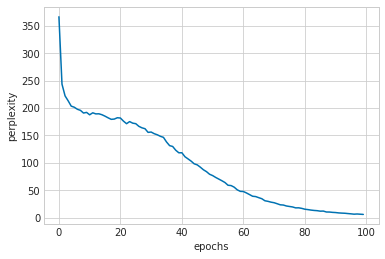

In [14]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()